In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import arviz as az
from celerite2 import terms as cterms
from celerite2 import GaussianProcess as cGaussianProcess
from celerite2.jax import GaussianProcess, terms
import chirp
import jax
import jax.lax
import jax.numpy as jnp
import jax.scipy.special as jsp
import matplotlib.pyplot as plt
import numpy as np
import numpyro
import numpyro.distributions as dist
from numpyro.infer import NUTS, MCMC, Predictive
import pandas as pd
import seaborn as sns
import xarray as xr

numpyro.set_host_device_count(10)

celerite2.jax only works with dtype float64. We're enabling x64 now, but you might run into issues if you've already run some jax code.
You can squash this warning by setting the environment variable 'JAX_ENABLE_X64=True' or by running:
>>> from jax import config
>>> config.update('jax_enable_x64', True)


We are trying to simulate several years of observations of a signal that has a true chirp with a frequency of (say) $6 \, \mathrm{yr}^{-1}$, superimposed on a DRW signal also with a time constant of $1/6 \, \mathrm{yr}$, whose RMS amplitudes are similar.  (Because the chirp is coherent, this means that it will have a *massive* SNR in these data.)

Observations are taken on average once every three days (but with several hours of random jitter); we randomly censor $1/3$ of these observations (local conditions?), and also three months out of each year (the object is too close to the sun to observe).  Observational uncertainties are about $10\%$ of the RMS variation of the DRW signal, but vary from observation to observation.

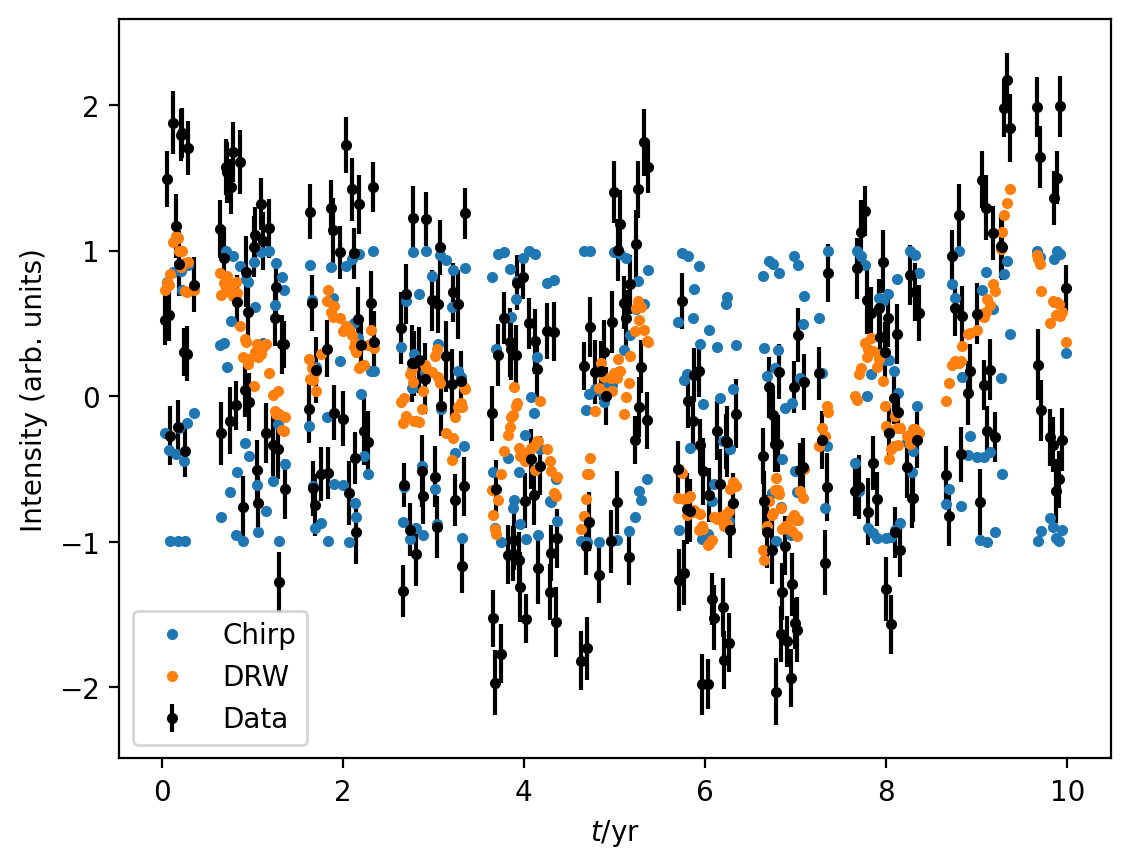

In [5]:
year = 1.0
day = 1.0/365.25
hour = day / 24.0
minute = hour / 60.0
second = minute / 60.0

T = 10*year

drop_out_fraction = 1/3

drw_amp = 0.6
drw_tau = 1 * year

mean_uncert = 0.2
sd_log_uncert = 0.1

# These are chosen so that the chirp time is ~15 years in the future---the mass is in funny units to ensure this!
chirp_f0 = 1 / (30*day)
chirp_w0 = 2*np.pi*chirp_f0
chirp_wdot = 0.35*chirp_w0 / T
chirp_mass, chirp_time = chirp.frequency_frequency_derivative_to_mc_tc(chirp_w0, chirp_wdot)
chirp_amp = 1.0
chirp_a, chirp_b = np.random.normal(0, 1, size=2)
r = np.sqrt(chirp_a**2 + chirp_b**2)
chirp_a = chirp_amp * chirp_a / r
chirp_b = chirp_amp * chirp_b / r

ts = np.arange(0, T, 6*day)
ts += np.random.uniform(-3*hour, 3*hour, size=ts.shape[0])
ts = ts[np.abs(ts % year - 0.5*year) > 0.25*year/2]
r = np.random.uniform(0, 1, size=ts.shape[0])
ts = ts[r > drop_out_fraction]

tmid = np.median(ts)
chirp_time = chirp_time - tmid
ts_centered = ts - tmid

chirp_wmid = chirp.chirp_frequency(0, chirp_time, chirp_mass)
chirp_wdotmid = chirp.chirp_frequency_derivative(0, chirp_time, chirp_mass)

drw_kernel = cterms.RealTerm(a=drw_amp*drw_amp, c=1/drw_tau)
drw_process = cGaussianProcess(kernel=drw_kernel, mean=0.0)

chirp_signal = chirp.chirp(ts_centered, chirp_a, chirp_b, chirp_time, chirp_mass)
drw_process.compute(ts)
drw_signal = drw_process.sample()
obs_uncert = np.random.lognormal(mean=np.log(mean_uncert), sigma=sd_log_uncert, size=ts.shape[0])
obs_noise = np.random.normal(loc=0, scale=obs_uncert)

data = chirp_signal + drw_signal + obs_noise

plt.errorbar(ts, data, yerr=obs_uncert, fmt='.', color='k', label='Data')
plt.plot(ts, chirp_signal, '.', label='Chirp')
plt.plot(ts, drw_signal, '.', label='DRW')
plt.xlabel(r'$t / \mathrm{yr}$')
plt.ylabel(r'Intensity (arb. units)')
plt.legend(loc='best')

In [33]:
from importlib import reload
reload(chirp)

<module 'chirp' from '/Users/wfarr/Research/DRWChirp/chirp.py'>

In [40]:
w0_guess = chirp_wmid
wdot0_guess = chirp_wdotmid
kernel = NUTS(chirp.drw_chirp_model, dense_mass=True)
sampler = MCMC(kernel, num_warmup=2000, num_samples=2000, num_chains=4)
sampler.run(jax.random.PRNGKey(np.random.randint(1<<32)), ts_centered, data, obs_uncert, w0=w0_guess, wdot0=wdot0_guess, wgridsize=(10,3))

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

In [41]:
trace = chirp.from_numpyro_with_generated_quantities(sampler, ts_centered, data, obs_uncert, w0=w0_guess, wdot0=wdot0_guess, wgridsize=(10,3))

array([[<Axes: ylabel='log_tau'>, <Axes: >, <Axes: >],
       [<Axes: ylabel='wmid'>, <Axes: >, <Axes: >],
       [<Axes: xlabel='log_drw_amp', ylabel='wdotmid'>,
        <Axes: xlabel='log_tau'>, <Axes: xlabel='wmid'>]], dtype=object)

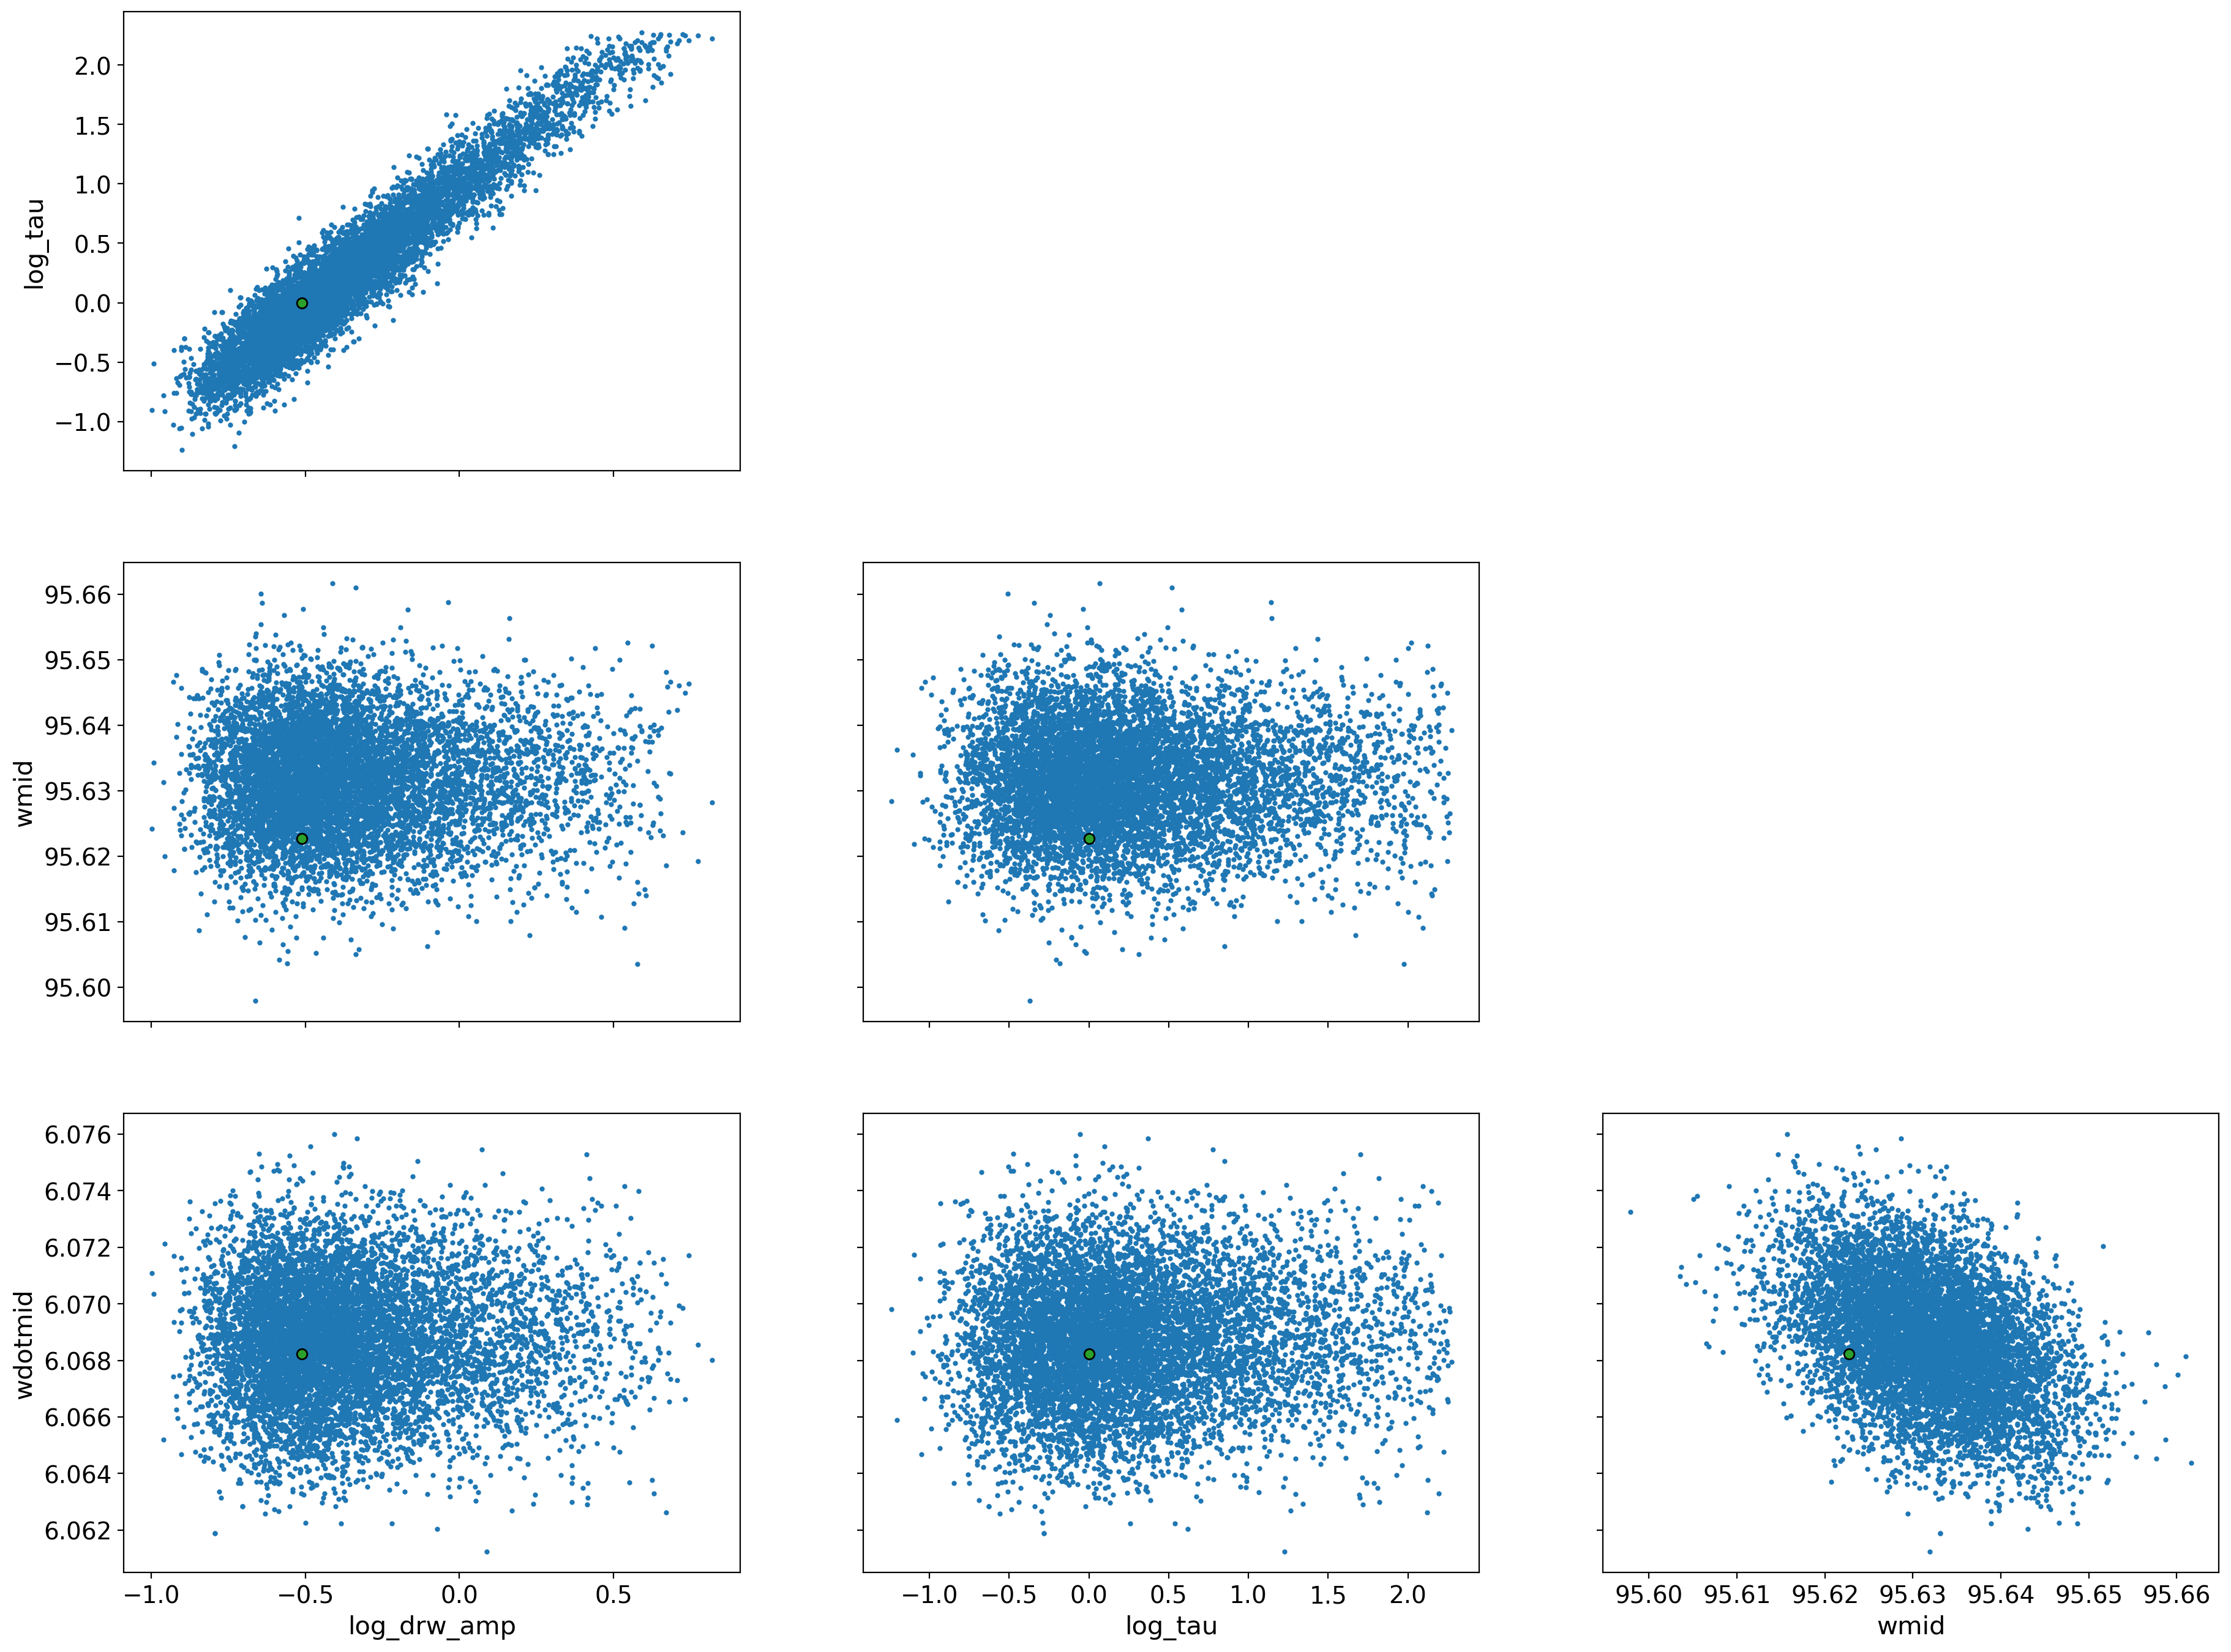

In [42]:
az.plot_pair(trace, var_names=['log_drw_amp', 'log_tau', 'wmid', 'wdotmid'], divergences=True,
             reference_values={'log_drw_amp': np.log(drw_amp), 'log_tau': np.log(drw_tau), 'wmid': chirp_wmid, 'wdotmid': chirp_wdotmid})

In [43]:
trace.log_likelihood.mean(dim='draw')

<xarray.Dataset> Size: 64B
Dimensions:   (chain: 4)
Coordinates:
  * chain     (chain) int64 32B 0 1 2 3
Data variables:
    log_like  (chain) float64 32B -45.14 -45.04 -45.0 -45.01

array([[<Axes: ylabel='wdotmid'>, <Axes: >, <Axes: >],
       [<Axes: ylabel='a'>, <Axes: >, <Axes: >],
       [<Axes: xlabel='wmid', ylabel='b'>, <Axes: xlabel='wdotmid'>,
        <Axes: xlabel='a'>]], dtype=object)

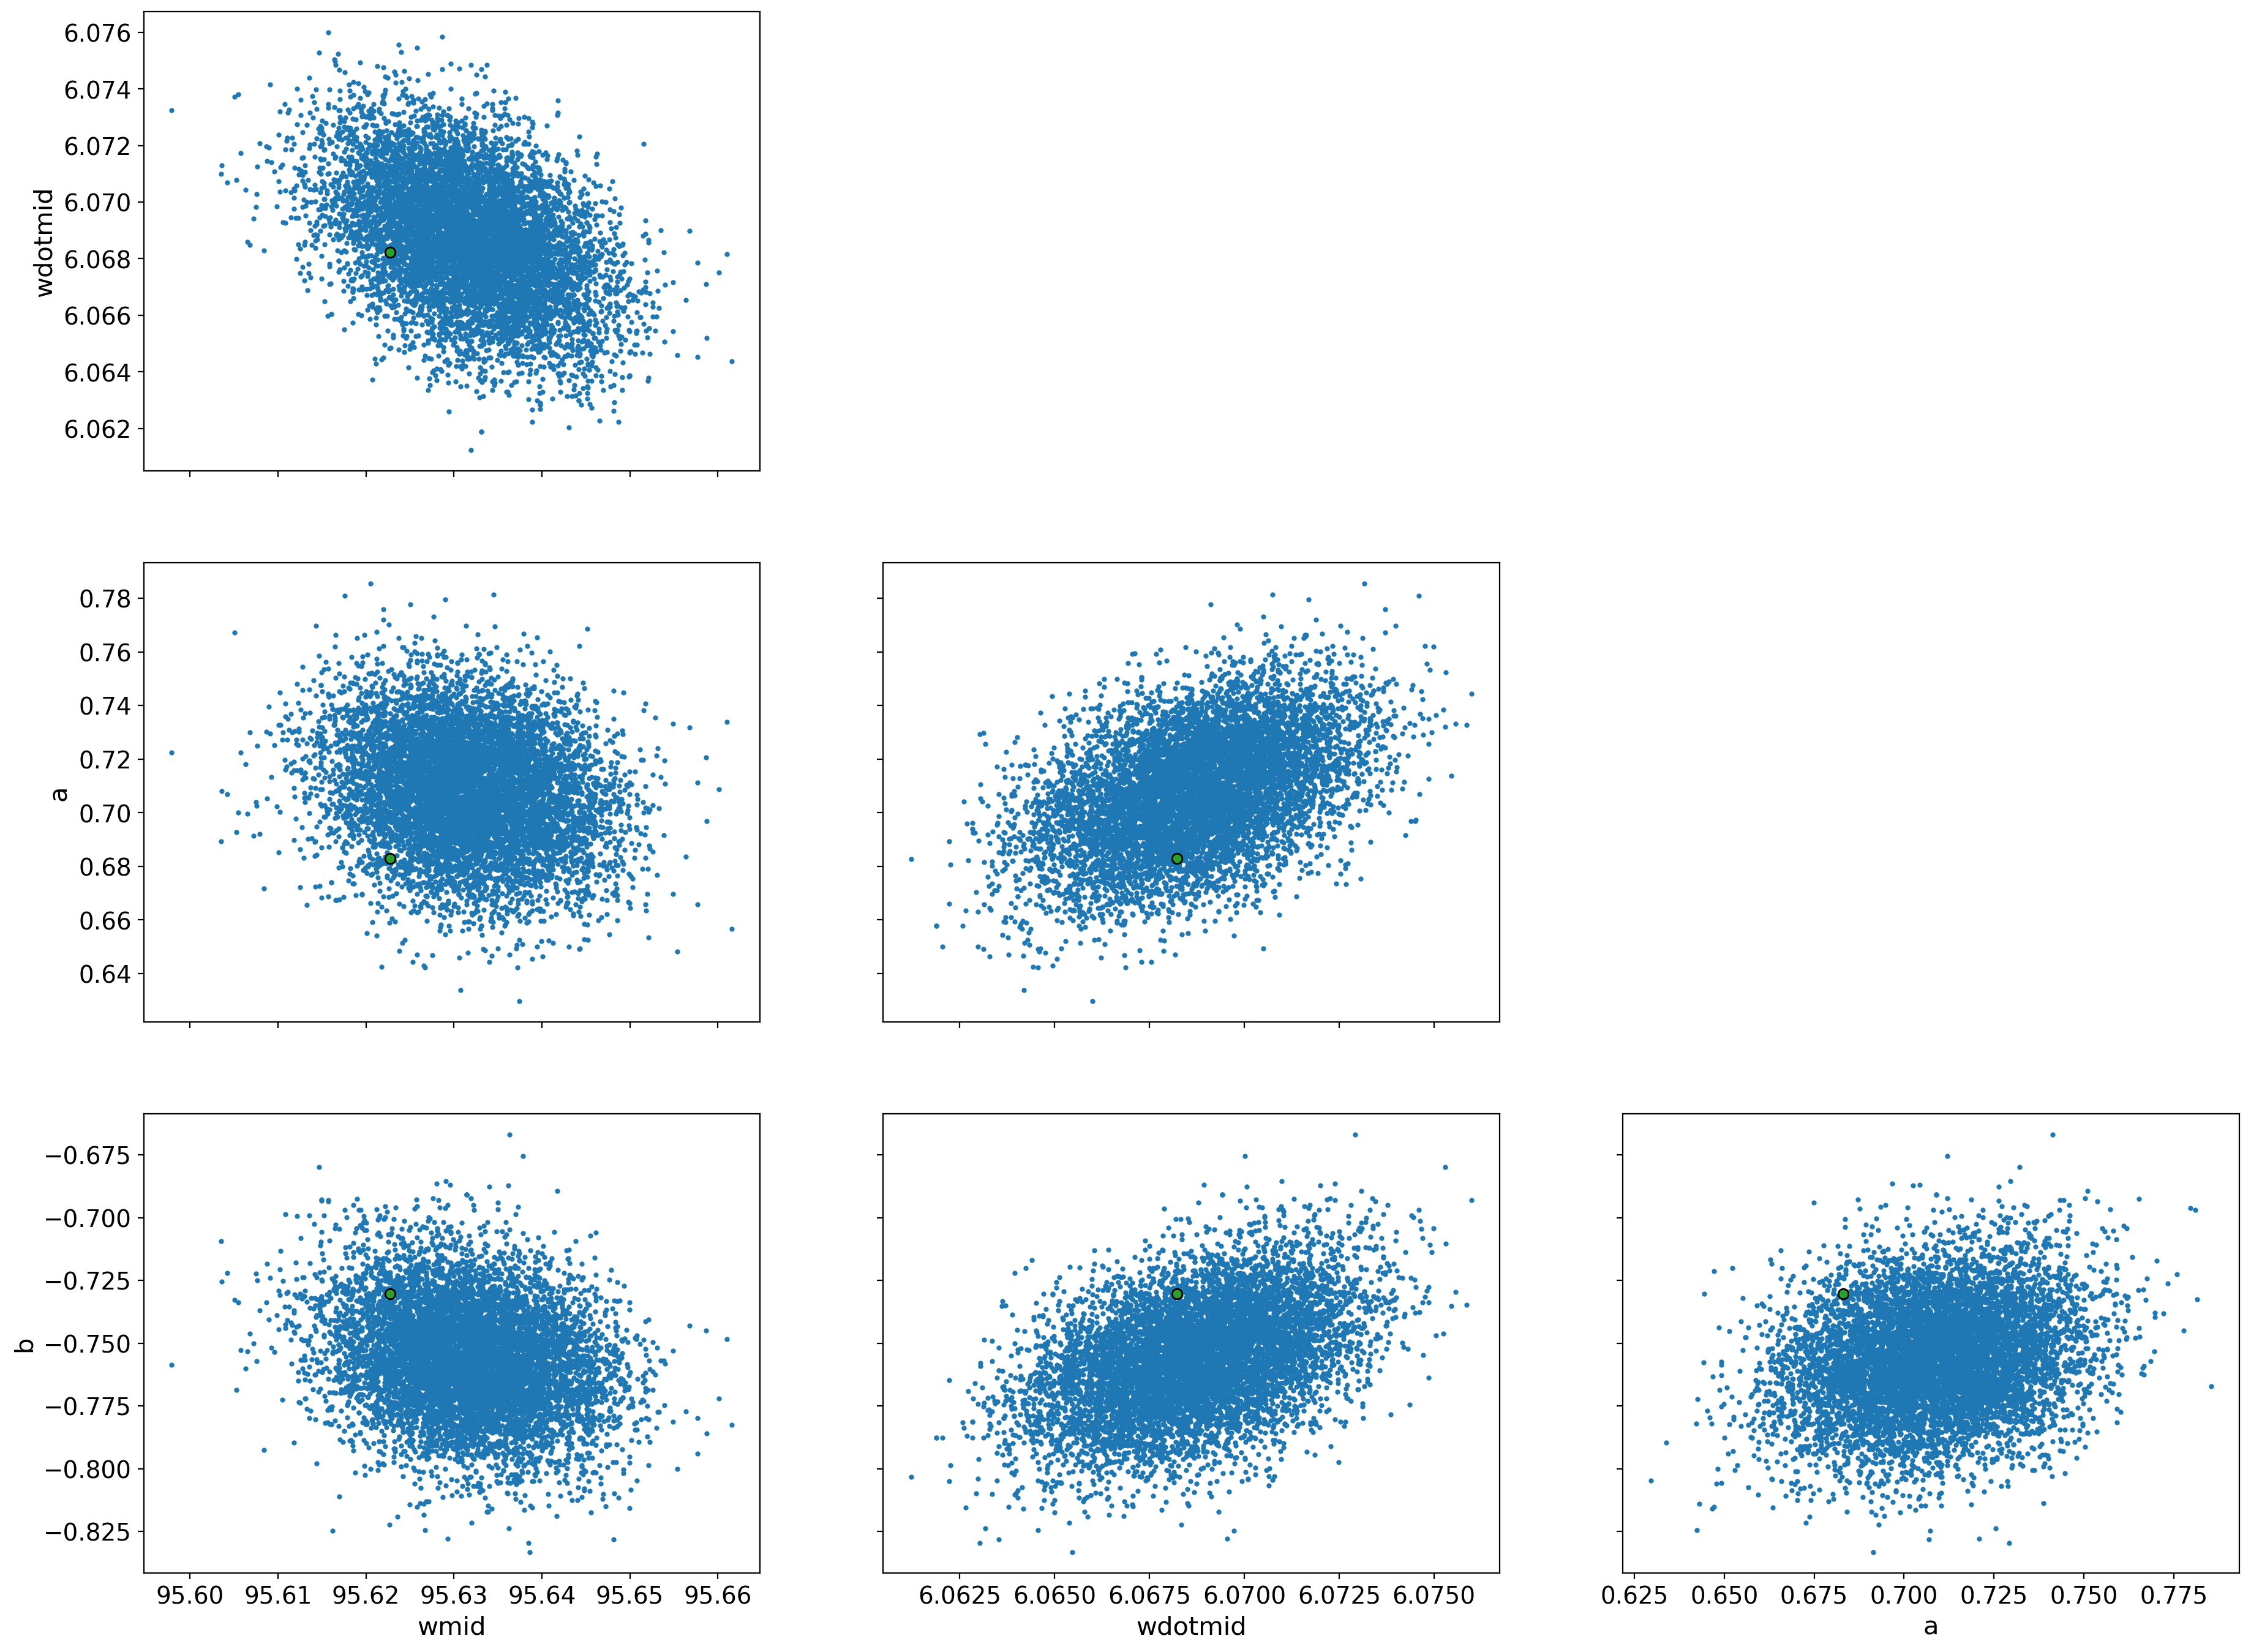

In [44]:
az.plot_pair(trace, var_names=['wmid', 'wdotmid', 'a', 'b'],
             reference_values={'wmid': chirp_wmid, 'wdotmid': chirp_wdotmid, 'a': chirp_a, 'b': chirp_b})

/Users/wfarr/miniconda3/envs/DRWChirp/lib/python3.12/site-packages/arviz/plots/traceplot.py:222: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (21), generating only 20 plots
  warnings.warn(
/Users/wfarr/miniconda3/envs/DRWChirp/lib/python3.12/site-packages/arviz/plots/backends/matplotlib/traceplot.py:217: UserWarning: A valid var_name should be provided, found {'wmid'} expected from {'wdotmid_restricted_unit', 'b', 'wdotmid_restricted', 'chirp_amp', 'tc', 'log_tau', 'a_unit', 'a', 'tau', 'wdotmid', 'kw0', 'drw_amp', 'b_unit', 'k0', 'chirp_signal', 'log_drw_amp', 'mc', 'wmid_restricted', 'kwdot0', 'wmid_restricted_unit'}
  warnings.warn(


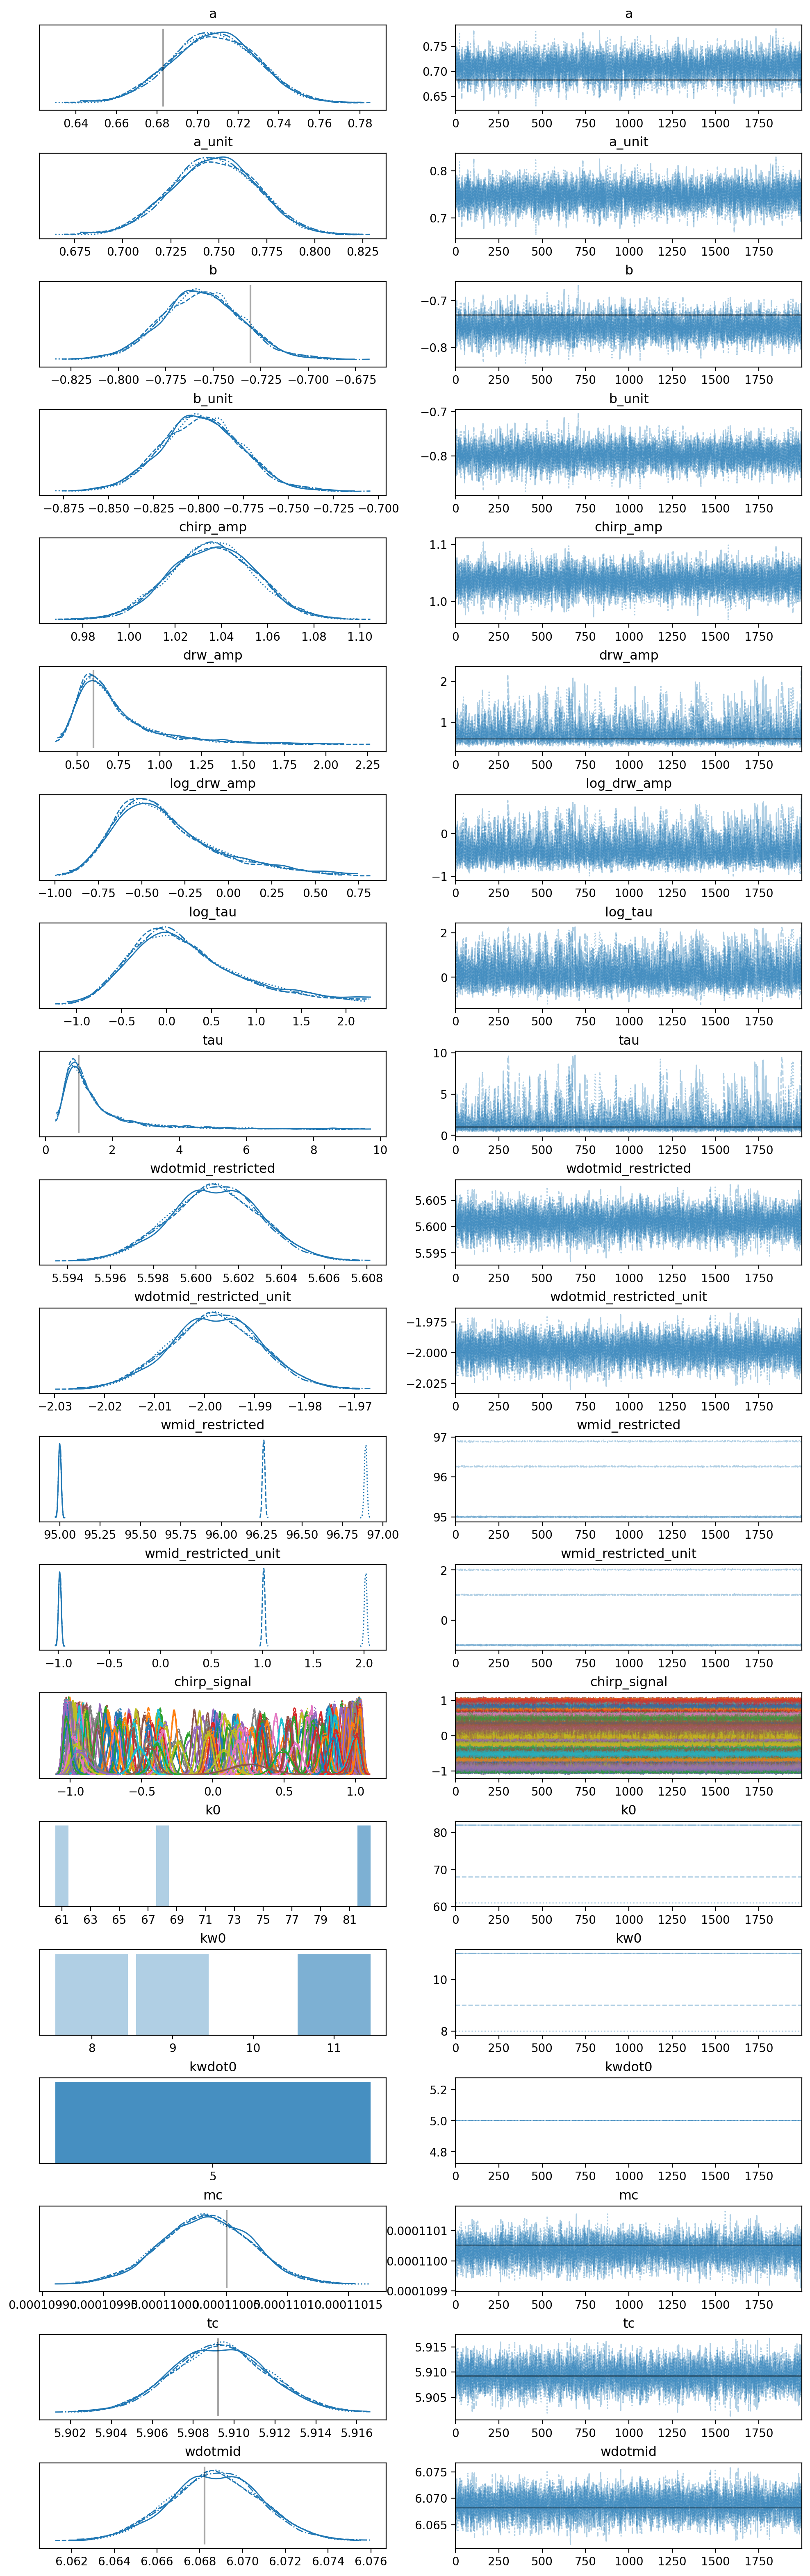

In [45]:
az.plot_trace(trace, lines=[('tau', {}, drw_tau), ('wmid', {}, chirp_wmid), ('mc', {}, chirp_mass), ('drw_amp', {}, drw_amp),
                            ('a', {}, chirp_a), ('b', {}, chirp_b), ('tc', {}, chirp_time), ('wdotmid', {}, chirp_wdotmid)])
plt.subplots_adjust(hspace=0.5)

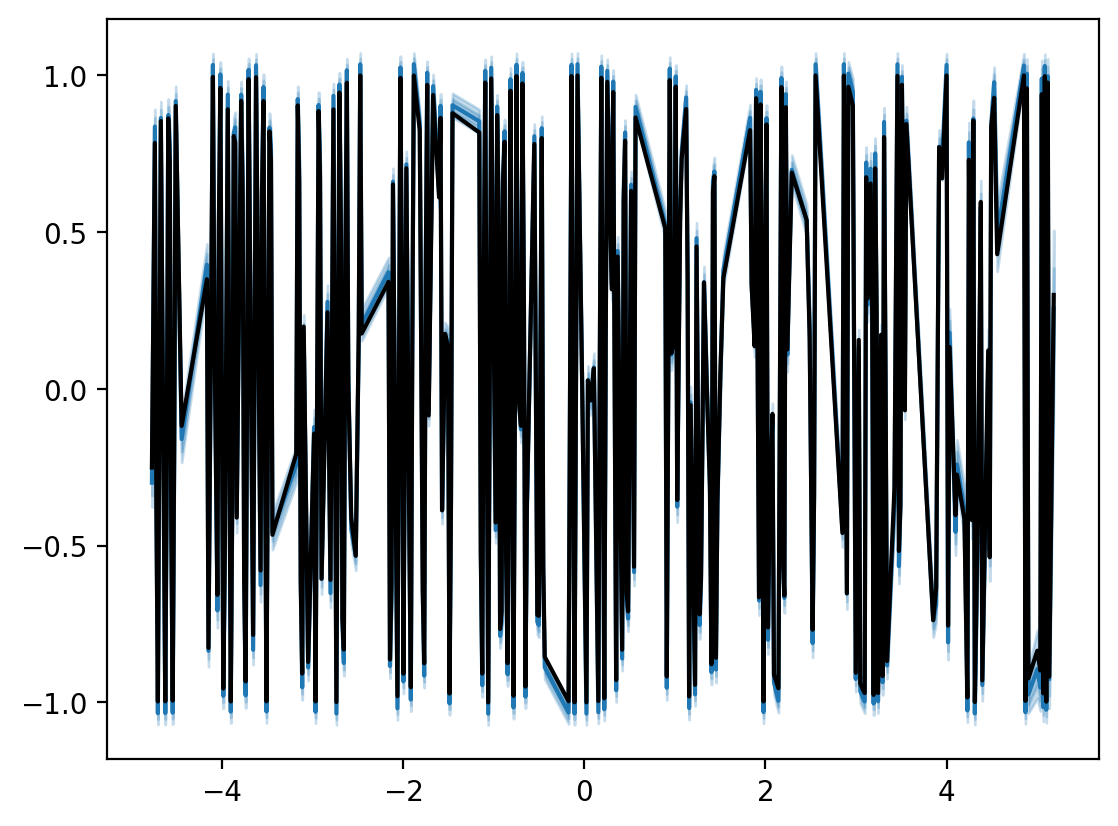

In [46]:
m = trace.posterior['chirp_signal'].median(dim=['chain', 'draw'])
h = trace.posterior['chirp_signal'].quantile(0.84, dim=['chain', 'draw'])
l = trace.posterior['chirp_signal'].quantile(0.16, dim=['chain', 'draw'])
hh = trace.posterior['chirp_signal'].quantile(0.975, dim=['chain', 'draw'])
ll = trace.posterior['chirp_signal'].quantile(0.025, dim=['chain', 'draw'])

line, = plt.plot(ts_centered, m)
plt.fill_between(ts_centered, l, h, color=line.get_color(), alpha=0.25)
plt.fill_between(ts_centered, ll, hh, color=line.get_color(), alpha=0.25)

plt.plot(ts_centered, chirp_signal, 'k')

We can think of the detection significance of the chirp signal as the number of s.d. the mean amplitude is from $0$:

A = 1.036 +/- 0.018, S/N = 56.1


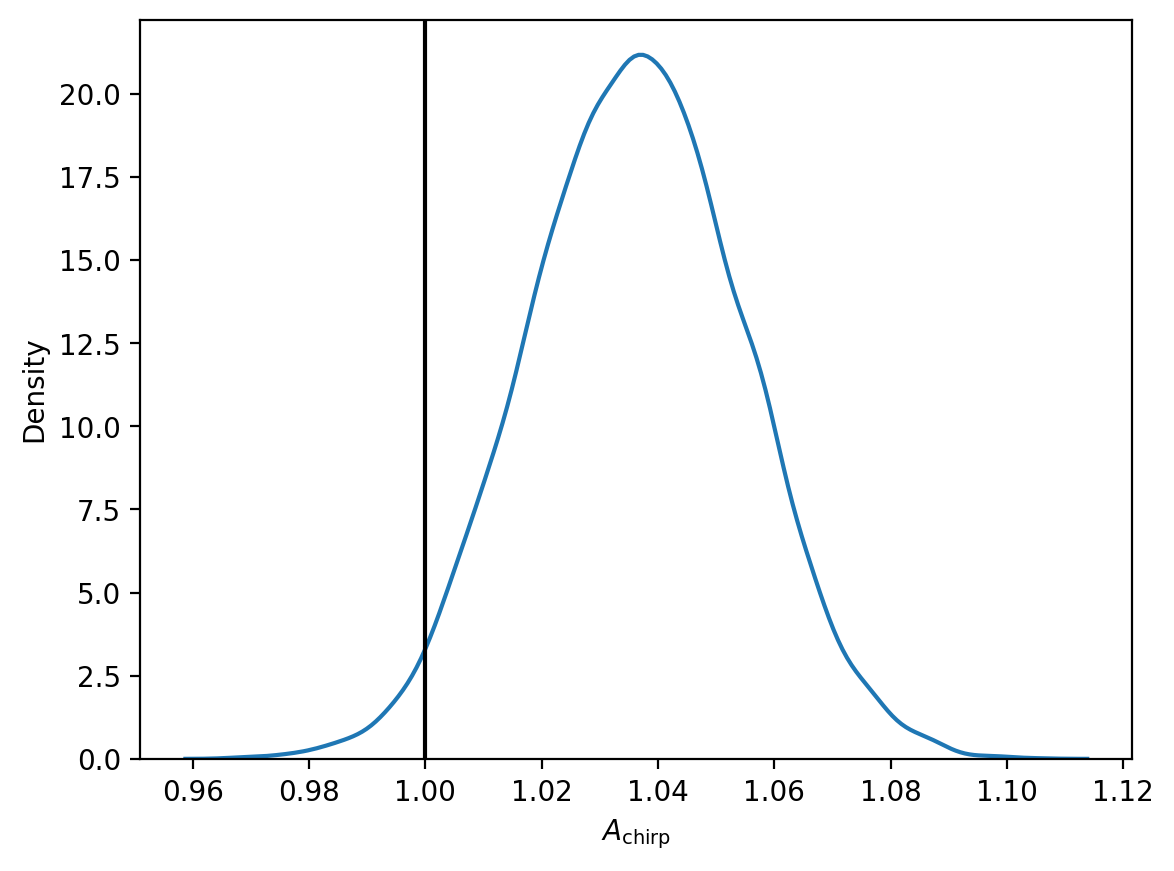

In [47]:
ca = trace.posterior.chirp_amp.values.flatten()
sns.kdeplot(ca)
plt.xlabel(r'$A_\mathrm{chirp}$')
plt.axvline(chirp_amp, color='k')
print('A = {:.3f} +/- {:.3f}, S/N = {:.1f}'.format(np.mean(ca), np.std(ca), np.mean(ca)/np.std(ca)))